<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/ImbalancedLearnPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 不均衡データからモデル作成する際に役立つimbalanced-learnの練習

### 動機
Kaggleでクレジットカードの不正利用を検出するコンペに参加している。  
クレジットカード決済データセットの場合、負例99% 正例1%など非常に偏りのあるデータになる。
クレジットカードに限らず、異常を検知するような課題の場合、このような不均衡なデータセットが多くを占める。
このようなデータセットの取り扱い方を、実装レベルで学んでいなかったので、
これを機に学ぶこととする。  
ちなみにインバランスはアンバランスの名詞らしいけど、現地の人も気にしてないらしいから
覚えなくていい。



[公式](https://imbalanced-learn.org/en/stable/install.html)

### 前提条件
The imbalanced-learn package requires the following dependencies:

numpy (>=1.11)  
scipy (>=0.17)  
scikit-learn (>=0.21)  
keras 2 (optional)  
tensorflow (optional)  

In [0]:
import numpy as np
import scipy as sp
import sklearn as sl

In [18]:
print('numpy=',np.__version__,'scipy=',sp.__version__,'sklearn=',sl.__version__)

numpy= 1.16.4 scipy= 1.3.0 sklearn= 0.21.3


前提条件問題なし

### インストール

In [19]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.5.0)


### プロット関数

In [0]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

### 0. Original

In [0]:
from sklearn.svm import LinearSVC

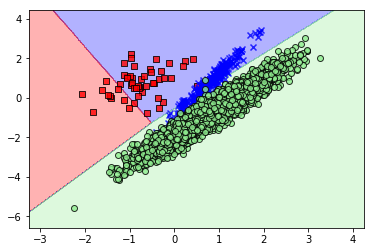

In [22]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
clf = LinearSVC()
linear_svm = clf.fit(X, y)
plot_decision_regions(X, y, clf, resolution=0.02)

### 2.Over-sampling

#### 2.1. A practical guide
[異なるオーバーサンプリングアルゴリズムの比較](https://imbalanced-learn.org/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py)

#### 2.1.1. Naive random over-sampling
少数クラスの新しいサンプルを生成する。
現在利用可能なサンプルを置き換えてランダムにサンプリングすることによって  新しいサンプルを生成する  。  
同じサンプルが複製されるので学習効果は薄いと思われる

[(0, 4674), (1, 4674), (2, 4674)]


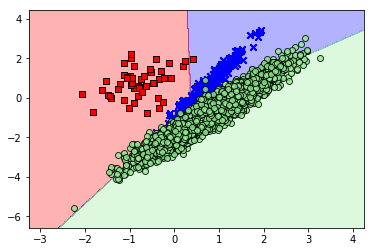

In [23]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))
linear_svm = clf.fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

少数クラスの分離が改善されている。  
ただ、他クラスに与える影響もでかい。  
複製されたサンプルは既存のサンプルと同じ位置にプロットされる。  
数字だけでなく文字列を含むデータもサンプリング可能。  
個人的な直感的理解ではマイノリティデータの特徴バイアスを強くするイメージだと考えている。　



#### 2.1.2. From random over-sampling to SMOTE and ADASYN
置換によるランダムサンプリングとは別に、マイノリティクラスをオーバーサンプリングする一般的な2つの方法があります。  
（i）合成マイノリティオーバーサンプリングテクニック（SMOTE）[CBHK2002]  
（ii）適応合成（ADASYN）[HBGL2008]サンプリングメソッド  
これらのアルゴリズムは同じ方法で使用できます。

[(0, 4674), (1, 4674), (2, 4674)]


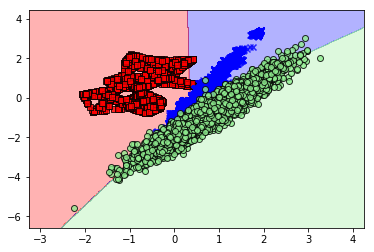

In [24]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items())) 
clf_smote = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_smote, resolution=0.02)

SMOTEはKNNを用いて、二つの少数派クラスの間に引かれた直線状にランダムに点を取るアルゴリズム。  
そのため、少数派クラスの空白地帯が少なくなっている。

[(0, 4673), (1, 4662), (2, 4674)]


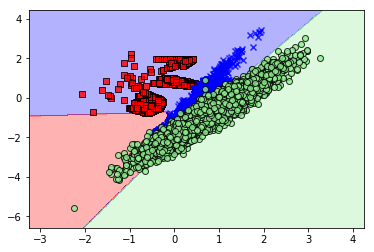

In [25]:
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_adasyn, resolution=0.02)

ADASYNは間違って分類された元のサンプルの隣にサンプルを生成することに焦点を当てている
以下、論文より抜粋。  
* ADASYNアルゴリズムの重要な考え方は、密度を使用すること
* 少数派と多数派の両方の精度が向上します。クラスを優先して1つのクラスを犠牲にしません  
* ADASYNは複数クラスに一般化可能

確かにプロット図を見るとオリジナルの密度の比率が保たれているように見える。

### 2.1.4. SMOTE variants
SMOTEはインライアーとアウトライアーを接続しますが、ADASYNはアウトライアーのみに焦点を合わせ、どちらの場合も最適でない決定関数につながる可能性があります。  
この点で、SMOTEはサンプルを生成するための3つの追加オプションを提供します。  
これらのメソッドは、最適な決定関数の境界付近のサンプルに焦点を当て、最近傍クラスの反対方向のサンプルを生成します。 これらのバリアントは下図に示されています。

[(0, 4674), (1, 4674), (2, 4674)]


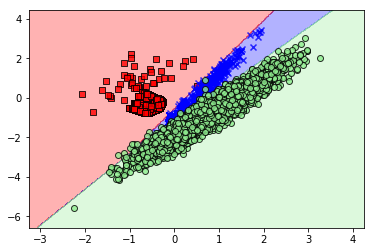

In [26]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf_brdSmote = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_brdSmote, resolution=0.02)

連続的およびカテゴリー的特徴などの混合データ型を処理する場合、提示されたメソッド（クラスRandomOverSamplerを除く）はいずれもカテゴリー的特徴を処理できません。 SMOTENC [CBHK2002]は、カテゴリデータが異なる方法で処理されるSMOTEアルゴリズムの拡張です

In [27]:
# create a synthetic data set with continuous and categorical features
rng = np.random.RandomState(42)
n_samples = 50
X = np.empty((n_samples, 3), dtype=object)
X[:, 0] = rng.choice(['A', 'B', 'C'], size=n_samples).astype(object)
X[:, 1] = rng.randn(n_samples)
X[:, 2] = rng.randint(3, size=n_samples)
y = np.array([0] * 20 + [1] * 30)
print(sorted(Counter(y).items()))

[(0, 20), (1, 30)]


このデータセットでは、最初と最後の機能がカテゴリ機能と見なされます。 これらの機能のインデックスまたはこれらの機能をマークするブールマスクのいずれかを渡すことにより、パラメーターcategorical_featuresを介してこの情報をSMOTENCに提供する必要があります。

In [35]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
print(X_resampled[-5:])

[(0, 30), (1, 30)]
[['A' 0.5246469549655818 2]
 ['B' -0.3657680728116921 2]
 ['A' 0.9344237230779993 2]
 ['B' 0.3710891618824609 2]
 ['B' 0.3327240726719727 2]]


#### 2.2.2。マルチクラス管理
すべてのアルゴリズムは、複数のクラスおよびバイナリクラスの分類で使用できます。 RandomOverSamplerは、サンプル生成中にクラス間情報を必要としません。したがって、各ターゲットクラスは個別にリサンプリングされます。それどころか、ADASYNとSMOTEの両方には、サンプル生成に使用される各サンプルの近傍に関する情報が必要です。各ターゲットクラスを選択し、単一のクラスにグループ化された残りのデータセットに対して必要な統計を計算することにより、1対残りのアプローチを使用しています。

### 3. Under-sampling
[異なるアンダーサンプリングアルゴリズムの比較](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py)　　

#### 3.1. Prototype generation
元のデータセットSが与えられると、プロトタイプ生成アルゴリズムは新しいセットS 'を生成します。  
Prototype generationは、対象クラスのサンプル数を減らしますが、残りのサンプルは元のセットから生成され、選択されません。  
Random under samplingでは有益なデータを削除してしまう可能性があります。一方で、クラスターベースの手法なら各クラスdistinctなデータ群となるため、一部の有益なデータのみを消す事はありません。

[(0, 64), (1, 262), (2, 4674)]


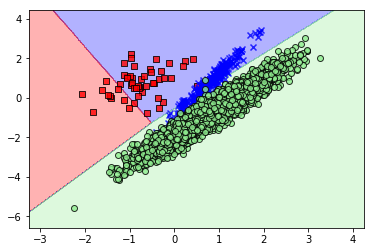

In [37]:
from collections import Counter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                               n_redundant=0, n_repeated=0, n_classes=3,
                               n_clusters_per_class=1,
                               weights=[0.01, 0.05, 0.94],
                               class_sep=0.8, random_state=0)
print(sorted(Counter(y).items()))
clf = LinearSVC().fit(X, y)
plot_decision_regions(X, y, clf, resolution=0.02)

[(0, 64), (1, 64), (2, 64)]


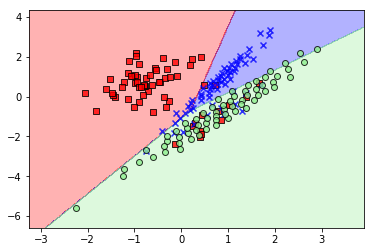

In [38]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

ClusterCentroidsは、サンプル数を減らしてデータクラスターを表す効率的な方法を提供します。この方法では、データをクラスターにグループ化する必要があることに注意してください。さらに、重心の数は、アンダーサンプリングされたクラスターが元のクラスターを代表するように設定する必要があります。

#### 3.2. Prototype selection
Prototype generationアルゴリズムとは対照的に、Prototype selectionアルゴリズムは元のセットからサンプルを選択します。  
さらに、これらのアルゴリズムは、（i）制御されたアンダーサンプリング手法と（ii）クリーニングアンダーサンプリング手法の2つのグループに分けることができます。メソッドの最初のグループは、S 'のサンプル数がユーザーによって指定されるアンダーサンプリング戦略を可能にします。対照的に、アンダーサンプリングテクニックのクリーニングでは、この仕様は許可されず、フィーチャスペースのクリーニングを目的としています。

#### 3.2.1. Controlled under-sampling techniques
RandomUnderSamplerは、対象クラスのデータのサブセットをランダムに選択することにより、データのバランスをとる高速で簡単な方法です。

[(0, 64), (1, 64), (2, 64)]


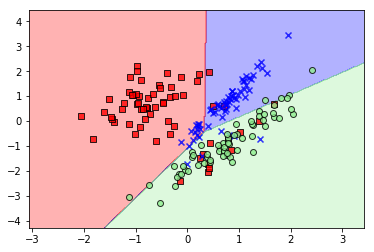

In [39]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

RandomUnderSamplerでは、replacementをTrueに設定することにより、データをブートストラップできます。複数のクラスでのリサンプリングは、各ターゲットクラスを個別に考慮することにより実行されます。

(192, 2)
(181, 2)


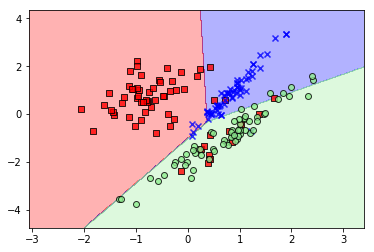

In [40]:
import numpy as np
print(np.vstack([tuple(row) for row in X_resampled]).shape)
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(np.vstack(np.unique([tuple(row) for row in X_resampled], axis=0)).shape)
clf = LinearSVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf, resolution=0.02)

さらに、RandomUnderSamplerを使用すると、異種データをサンプリングできます（たとえば、いくつかの文字列を含む）。

In [41]:
X_hetero = np.array([['xxx', 1, 1.0], ['yyy', 2, 2.0], ['zzz', 3, 3.0]],dtype=np.object)
y_hetero = np.array([0, 0, 1])
X_resampled, y_resampled = rus.fit_resample(X_hetero, y_hetero)
print(X_resampled)
print(y_resampled)

[['xxx' 1 1.0]
 ['zzz' 3 3.0]]
[0 1]



NearMissは、いくつかのヒューリスティックルールを追加してサンプルを選択します[MZ2003]。 NearMissは、パラメーターバージョンで選択できる3種類のヒューリスティックを実装しています。

Minority classのサンプルのうち近くにあるkサンプルからの平均距離が小さいMajority classのサンプルを残します。  

NearMissのヒューリスティックルールは最近傍アルゴリズムに基づいています。したがって、パラメーターn_neighborsおよびn_neighbors_ver3は、scikit-learnのKNeighborsMixinから派生した分類子を受け入れます。前者のパラメーターは、近隣までの平均距離を計算するために使用され、後者は、対象のサンプルの事前選択に使用されます。

特定のクラスをアンダーサンプリングする場合、NearMiss-1はノイズの存在によって変更される可能性があります。通常の場合、境界の隣のサンプルが選択されます。  
NearMiss-2は、最も近いサンプルではなく、最も遠いサンプルに焦点を合わせているため、この効果はありません。ノイズの存在は、主に周辺外れ値の存在下でサンプリングを変更することも想像できます。   
NearMiss-3はおそらく、最初のステップでサンプルを選択するため、ノイズの影響を受けにくいバージョンです。

[(0, 64), (1, 64), (2, 64)]


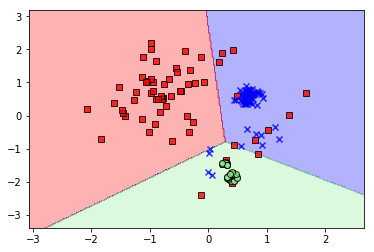

In [44]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X_resampled_nm1, y_resampled = nm1.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled_nm1, y_resampled)
plot_decision_regions(X_resampled_nm1, y_resampled, clf, resolution=0.02)

[(0, 64), (1, 64), (2, 64)]


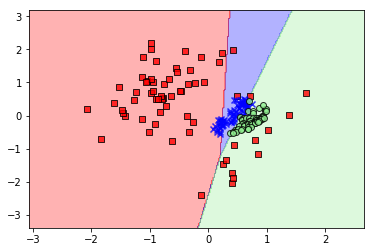

In [46]:
nm2 = NearMiss(version=2)
X_resampled_nm2, y_resampled = nm2.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled_nm2, y_resampled)
plot_decision_regions(X_resampled_nm2, y_resampled, clf, resolution=0.02)

/usr/local/lib/python3.6/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:192: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'
/usr/local/lib/python3.6/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:192: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'


[(0, 64), (1, 44), (2, 56)]


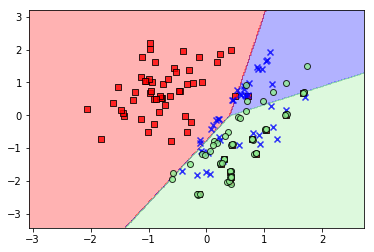

In [47]:
nm3 = NearMiss(version=3)
X_resampled_nm3, y_resampled = nm3.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
clf = LinearSVC().fit(X_resampled_nm3, y_resampled)
plot_decision_regions(X_resampled_nm3, y_resampled, clf, resolution=0.02)

## 工事中